In [91]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test.csv', 'sampleSubmission.csv', 'train.csv']


In [92]:
df = pd.read_csv('../input/train.csv', parse_dates=[0])
test = pd.read_csv('../input/test.csv', parse_dates=[0])

In [93]:
df.rename(columns={'count': 'rentals'}, inplace=True)

In [94]:
df = df.append(test, sort=False)

In [95]:
for col in ['rentals', 'registered', 'casual']:
    df[col] = np.log(df[col] + 1)

In [96]:
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['dayofweek'] = df['datetime'].dt.dayofweek
df['hour'] = df['datetime'].dt.hour

In [97]:
df.set_index('datetime', inplace=True)

In [98]:
df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,rentals,year,month,day,dayofweek,hour
datetime,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,1.386294,2.639057,2.833213,2011,1,1,5,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,2.197225,3.496508,3.713572,2011,1,1,5,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,1.791759,3.332205,3.496508,2011,1,1,5,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,1.386294,2.397895,2.639057,2011,1,1,5,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0.000000,0.693147,0.693147,2011,1,1,5,4


In [99]:
df.resample('30Min')['temp'].mean().fillna(method='ffill')

datetime
2011-01-01 00:00:00     9.84
2011-01-01 00:30:00     9.84
2011-01-01 01:00:00     9.02
2011-01-01 01:30:00     9.02
2011-01-01 02:00:00     9.02
2011-01-01 02:30:00     9.02
2011-01-01 03:00:00     9.84
2011-01-01 03:30:00     9.84
2011-01-01 04:00:00     9.84
2011-01-01 04:30:00     9.84
2011-01-01 05:00:00     9.84
2011-01-01 05:30:00     9.84
2011-01-01 06:00:00     9.02
2011-01-01 06:30:00     9.02
2011-01-01 07:00:00     8.20
2011-01-01 07:30:00     8.20
2011-01-01 08:00:00     9.84
2011-01-01 08:30:00     9.84
2011-01-01 09:00:00    13.12
2011-01-01 09:30:00    13.12
2011-01-01 10:00:00    15.58
2011-01-01 10:30:00    15.58
2011-01-01 11:00:00    14.76
2011-01-01 11:30:00    14.76
2011-01-01 12:00:00    17.22
2011-01-01 12:30:00    17.22
2011-01-01 13:00:00    18.86
2011-01-01 13:30:00    18.86
2011-01-01 14:00:00    18.86
2011-01-01 14:30:00    18.86
                       ...  
2012-12-31 08:30:00     5.74
2012-12-31 09:00:00     7.38
2012-12-31 09:30:00     7.38
2012-

In [100]:
df.sort_index(inplace=True)

In [101]:
df.reset_index(inplace=True)

In [102]:
df.tail()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,rentals,year,month,day,dayofweek,hour
17374,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN,2012,12,31,0,19
17375,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN,2012,12,31,0,20
17376,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,NaN,NaN,NaN,2012,12,31,0,21
17377,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,NaN,NaN,NaN,2012,12,31,0,22
17378,2012-12-31 23:00:00,1,0,1,1,10.66,13.635,65,8.9981,NaN,NaN,NaN,2012,12,31,0,23


In [103]:
df['rolling_temp'] = df['temp'].rolling(4, min_periods=1).mean()

In [104]:
test = df[df['rentals'].isnull()]
df = df[~df['rentals'].isnull()]

In [105]:
df.shape, test.shape

((10886, 18), (6493, 18))

In [106]:
removed_cols = ['rentals', 'casual', 'registered', 'datetime']
feats = [c for c in df.columns if c not in removed_cols]

In [107]:
from sklearn.model_selection import train_test_split
train, valid = train_test_split(df, random_state=42)

In [108]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state=42, n_estimators=100, n_jobs=-1)

In [109]:
rf.fit(train[feats], train['rentals'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [110]:
preds = rf.predict(valid[feats])

In [111]:
from sklearn.metrics import mean_squared_error
mean_squared_error(valid['rentals'], preds)**(1/2)

0.2973745268552469

In [112]:
test['count'] = np.exp(rf.predict(test[feats])) - 1

In [113]:
test[['datetime', 'count']].to_csv('rf1.csv', index=False)

## Modelo 2

In [114]:
# Separando a validação de forma diferente
train, valid = df[df['day'] <= 15], df.query("day > 15")
rf.fit(train[feats], train['rentals'])
preds = rf.predict(valid[feats])
mean_squared_error(valid['rentals'], preds)**(1/2)

0.33487367775020677

In [115]:
# Gerando o output da competição
test['count'] = np.exp(rf.predict(test[feats])) - 1
test[['datetime', 'count']].to_csv('rf2.csv', index=False)

## Modelo 3

In [116]:
# Separando a validação de forma diferente
rf = RandomForestRegressor(random_state=42, n_estimators=100, n_jobs=-1, oob_score=True)
rf.fit(df[feats], df['rentals'])
rf.oob_score_

0.9559115619794903

In [117]:
mean_squared_error(df['rentals'], rf.oob_prediction_)**(1/2)

0.29803261095382877

In [118]:
# Gerando o output da competição
test['count'] = np.exp(rf.predict(test[feats])) - 1
test[['datetime', 'count']].to_csv('rf3.csv', index=False)

# Modelo 4

In [124]:
def cv(df, test, feats, y_name, k=5):
    preds, score, fis = [], [], []
    chunk = df.shape[0] // k
    
    for i in range(k):
        if i+ 1 < k:
            valid = df.iloc[i*chunk: (i+1)*chunk]
            train = df.iloc[:i*chunk].append(df.iloc[(i+1)*chunk:])
        else:
            valid = df.iloc[i*chunk:]
            train = df.iloc[:i*chunk]
            
        rf = RandomForestRegressor(random_state=42, n_jobs=-1, n_estimators=100)
        rf.fit(train[feats], train[y_name])
        score.append(mean_squared_error(valid[y_name], rf.predict(valid[feats])) ** (1/2))
        preds.append(rf.predict(valid[feats]))
        fis.append(rf.feature_importances_)
        print(i, 'OK')
    
    return score, preds, fis

In [125]:
score, preds, fis = cv(df, test, feats, 'rentals')

0 OK
1 OK
2 OK
3 OK
4 OK


In [126]:
score

[0.6998833082922062,
 0.36816927689540974,
 0.47110110227148155,
 0.36756987410765024,
 0.3896309139685279]

In [130]:
test['count'] = np.exp(pd.DataFrame(preds).mean())

In [131]:
test[['datetime', 'count']].to_csv('rf4.csv', index=False)

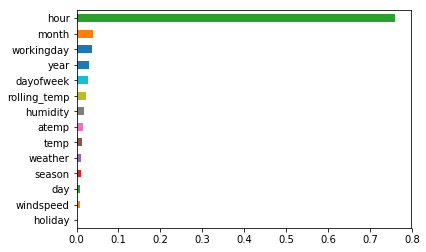

In [129]:
pd.DataFrame(fis, columns=feats).mean().sort_values().plot.barh()